# Goal : compute the alpha parameter as in https://arxiv.org/pdf/1909.02042.pdf

# $\alpha = 2.5 \frac{d logN(<m)}{dm}$

#TODO : 
- having a code that returns plots and m_cut, alpha_cut, m_cut_null for each selection + using the full cosmoDC2
- having a code that compute and store random catalogs different sample of source and lens
- having a code that compute and store correlation function

In [9]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u

In [10]:
import magnification_library
from scipy.optimize import curve_fit

In [11]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [12]:
import scipy.interpolate as itp
from scipy import stats

In [13]:
def polyn(x, a, b, c):
    p = 0.5*a * x**2 + b * x + c
    return p 

In [14]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [15]:
cosmo = extragalactic_cat.cosmology

In [16]:
#DC2 full
filters = ['mag_i_lsst<20.5', 'redshift>0.4','redshift<0.45']


#filters = ['redshift<10', 'mag_i_lsst<26.']

gal_selection = extragalactic_cat.get_quantities(['is_central', 'halo_mass','mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst', 'redshift','ra', 'dec', 'shear_1', 'shear_2', 'convergence'], filters=filters)

In [19]:
gal_cat = Table(gal_selection)
len(gal_cat)/1e6

0.014249

In [362]:
mmin, mmax = 10, 31.
binsize = 0.01
nbins = int((mmax - mmin)/binsize)

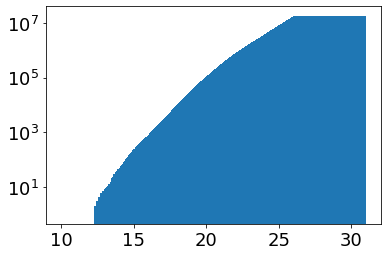

In [363]:
mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=nbins, range=[mmin,mmax], cumulative=True, label='all');
plt.yscale('log')

In [375]:
N = mag_hist[0][mag_hist[0]>0]
mi = bin_center(mag_hist[1])[mag_hist[0]>0]
logN = np.log10(N)

In [374]:
logN[N>0]

array([0.        , 0.        , 0.        , ..., 7.24942335, 7.24942335,
       7.24942335])

In [376]:
param = np.zeros((3,mi.size - 100))
dlogNdm = np.zeros((mi.size - 100))

for j in range(mi.size - 100):
    i = j + 50
    popt, pcov = curve_fit(polyn, mi[i-50:i+50], logN[i-50:i+50])
    param[:,j] = popt  
    dlogNdm[j] = popt[0]*mi[i]+popt[1]

In [417]:
popt

array([ 8.59188257e-08, -2.61945482e-06,  7.24946328e+00])

In [377]:
falpha = itp.interp1d(mi[50:-50], 2.5*dlogNdm)
falpha_inv = itp.interp1d(2.5*dlogNdm, mi[50:-50])

In [378]:
snr = (abs(falpha.y - 1)*np.sqrt(N[50:-50]))

In [379]:
mag_lim = 26.

m_cut = falpha.x[np.argmax(snr[falpha.x<mag_lim])]
m_cut_null = falpha_inv(1)
alpha_cut = falpha(m_cut)

Text(0, 0.5, '$|\\alpha - 1|$')

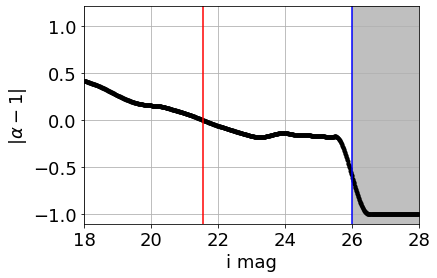

In [380]:
plt.plot(falpha.x, falpha.y - 1 ,'k.')
plt.grid()

plt.axvspan(26, 32, color='grey', alpha=0.5, lw=0)

plt.axvline(m_cut_null, color='red')
plt.axvline(m_cut, color='blue')


plt.xlim(18,28)

plt.xlabel('i mag')
plt.ylabel('$|\\alpha - 1|$')

Text(0, 0.5, '$|\\alpha - 1|\\sqrt{N_s}$')

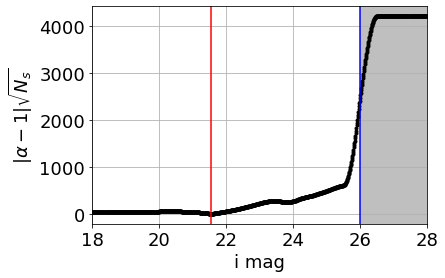

In [381]:
plt.plot(falpha.x, snr,'k.')

plt.axvspan(26, 32, color='grey', alpha=0.5, lw=0)

plt.xlim(18,28)

plt.axvline(m_cut_null, color='red')
plt.axvline(m_cut, color='blue')

plt.grid()

plt.xlabel('i mag')
plt.ylabel('$|\\alpha - 1|\sqrt{N_s}$')

In [200]:
print("Magnitude cut that maximize the snr =", m_cut, ", corresponding alpha value =", alpha_cut, ", magnitude cut for null test = ", m_cut_null)

Magnitude cut that maximize the snr = 25.47740740740741 , corresponding alpha value = 0.6137688055110688 , magnitude cut for null test =  20.839658227737583


# Put everything in functions 

In [127]:
def alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null):
    plt.figure()
    plt.hist(mag,bins=nbins, range=[mmin,mmax], cumulative=True, label='all')
    plt.yscale('log')
    plt.xlabel('i mag')
    plt.ylabel('cum. counts')
    
    plt.figure(figsize = (8,6))
    plt.subplot(211)
    plt.plot(falpha.x, falpha.y - 1 ,'k.')
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red')
    plt.axvline(m_cut, color='blue')
    plt.xlim(mmin,mag_lim+2.)
    plt.xlabel('i mag')
    plt.ylabel('$\\alpha - 1$')
    plt.grid()
    
    plt.subplot(212)   
    plt.plot(falpha.x, snr,'k.')
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red',label='m_cut_null')
    plt.axvline(m_cut, color='blue',label='m_cut')
    plt.xlim(mmin,mag_lim+2.)
    plt.xlabel('i mag')  
    plt.ylabel('$|\\alpha - 1|\sqrt{N_s}$')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    return 

In [158]:
def alpha_derivation(mag, mmin, mmax, binsize, mag_lim, show_plots='False'):
    
    nbins = int((mmax - mmin)/binsize)
    mag_hist = stats.cumfreq(mag, numbins=nbins, defaultreallimits=[mmin,mmax])
    #mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=nbins, range=[mmin,mmax], cumulative=True, label='all');
    
    N = mag_hist.cumcount[mag_hist.cumcount>0]
    #N = mag_hist[0][mag_hist[0]>0]
    mi = (np.linspace(mmin, mmax, nbins+1)[:-1] + binsize/2.)[mag_hist.cumcount>0]
    #mi = bin_center(mag_hist[1])[mag_hist[0]>0]
    logN = np.log10(N)
    
    param = np.zeros((3,mi.size - 100))
    dlogNdm = np.zeros((mi.size - 100))

    for j in range(mi.size - 100):
        i = j + 50
        popt, pcov = curve_fit(polyn, mi[i-50:i+50], logN[i-50:i+50], maxfev=20000, p0=(0,0,0)) 
        param[:,j] = popt  
        dlogNdm[j] = popt[0]*mi[j]+popt[1]
        
    falpha = itp.interp1d(mi[50:-50], 2.5*dlogNdm)
    snr = (abs(falpha.y - 1)*np.sqrt(N[50:-50]))
    
    m_cut = falpha.x[np.argmax(snr[falpha.x<mag_lim])]
    alpha_cut = float(falpha(m_cut))
    
    y0, tol = 1., 1e-4 
    xnew = np.linspace(falpha.x.min(), falpha.x.max(), int(1e6))
    ind = np.where(abs(falpha(xnew) - y0) < tol)[0]
    s = xnew[ind]
    
    if s.size> 0:
        m_cut_null = np.max(s)
    else :
        m_cut_null = -1.
    
    if show_plots:
        alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null)
    
    return m_cut, alpha_cut, m_cut_null

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(25.904999999999998, 1.244503402566024, 25.66287108787109)

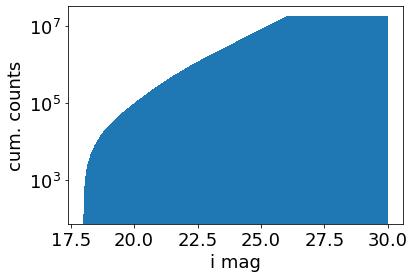

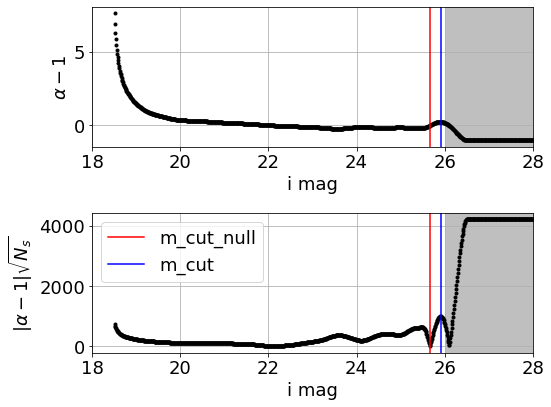

In [107]:
alpha_derivation(gal_cat['mag_i_lsst'], 18, 30, 0.01, 26., show_plots='True')

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(25.505, 0.7171060943096652, 22.053861378861377)

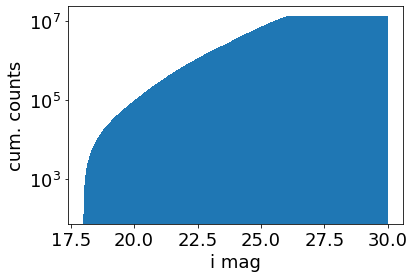

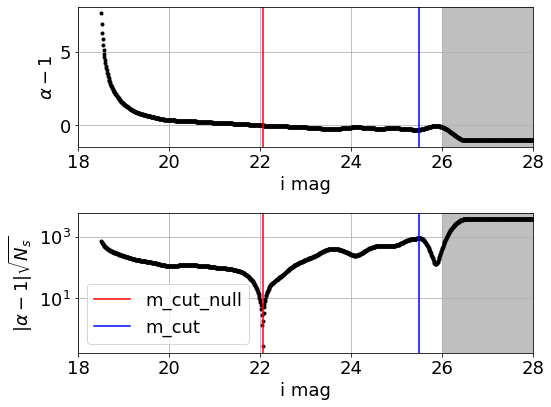

In [146]:
alpha_derivation(gal_cat['mag_i_lsst'], 18, 30, 0.01, 26., show_plots='True')

# Use defined background selection 

In [137]:
#DC2 full
#filters = ['mag_i_lsst<25.','redshift>0.9','redshift<1.1'] 


filters = ['redshift<10', 'mag_i_lsst<26.', 'halo_id>-1']

gal_selection = extragalactic_cat.get_quantities(['is_central', 'halo_mass','mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst', 'redshift','ra', 'dec', 'shear_1', 'shear_2', 'convergence'], filters=filters)

In [138]:
gal_cat = Table(gal_selection)
len(gal_cat)/1e6

13.294067

In [10]:
gal_cat = Table(gal_selection)
len(gal_cat)/1e6

17.759198

In [139]:
u_min_g = gal_cat['mag_u_lsst'] - gal_cat['mag_g_lsst']
g_min_r = gal_cat['mag_g_lsst'] - gal_cat['mag_r_lsst']
r_min_i = gal_cat['mag_r_lsst'] - gal_cat['mag_i_lsst']

r_min_z = gal_cat['mag_r_lsst'] - gal_cat['mag_z_lsst']
g_min_i = gal_cat['mag_g_lsst'] - gal_cat['mag_i_lsst']

In [140]:
LBG = (u_min_g > 0.33 * r_min_i + 0.87) * (r_min_i<0.28)  

In [141]:
LBGp = LBG * (u_min_g>1.4)

In [142]:
Udrop = (u_min_g>1.5) * (g_min_r> -1.) * (g_min_r<1.2) * (1.5*g_min_r < u_min_g-0.75)

In [143]:
Udropp = Udrop * (r_min_z<0.5)

In [144]:
CCseq_ll = 2.276 * (r_min_z) - 0.152
CCseq_T = -1/2.276 * (r_min_z) - 0.152/2.276**2

rzseq_ll = - 0.0248 * gal_cat['mag_z_lsst'] + 1.604

red_color1 = g_min_i - CCseq_ll

red_color2 = (g_min_i - CCseq_T) / (1 + 1/2.276**2)

blue_color1 = (r_min_z - rzseq_ll)
blue_color2 = red_color2

In [145]:
#selection to avoid cluster galaxies at z<0.4
sel_red1 = (red_color1 < -0.7) * (red_color2 < 4.) * (r_min_z>0.5) # * (gal_cat['mag_i_lsst']>21)
sel_blue1 = ((blue_color1 < -0.8) | ((blue_color2 < 0.5) * (g_min_i < 4)))  * (r_min_z<0.5) # * (gal_cat['mag_i_lsst']>22)

#selection to avoid cluster galaxies at z>0.4
sel_red2 = (red_color1 < -0.8) * (red_color2 < 1.7) * (r_min_z>0.5)  #* (gal_cat['mag_z_lsst']>21)
sel_blue2 = ((blue_color1 < -0.9) | ((blue_color2 < 0.3) * (g_min_i < 4)))  * (r_min_z<0.5)  # * (gal_cat['mag_i_lsst']>22)


(25.224999999999998, 0.8183966732404513, 22.7334942984943)

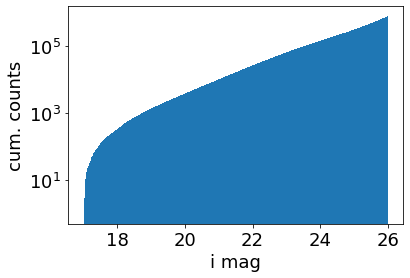

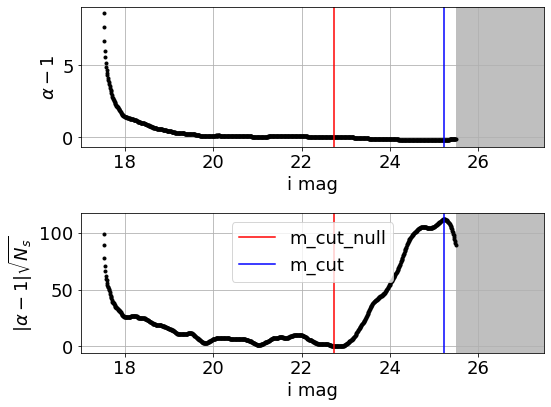

In [108]:
alpha_derivation(gal_cat['mag_i_lsst'][LBG], 17., 26, 0.01, 25.5, show_plots='True')

(25.215, 0.26829597941776306, 20.627889392889394)

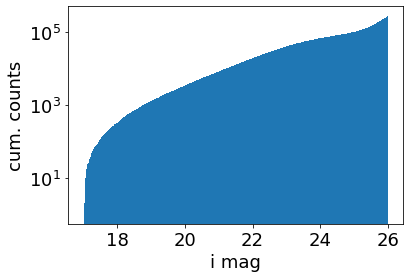

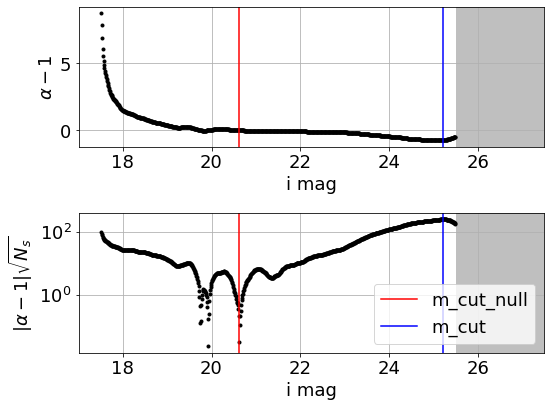

In [147]:
alpha_derivation(gal_cat['mag_i_lsst'][LBG], 17., 26, 0.01, 25.5, show_plots='True')

(25.495, 3.9162439119650516, 24.84236310736311)

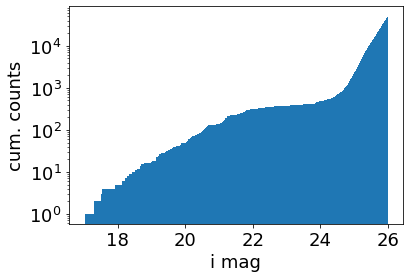

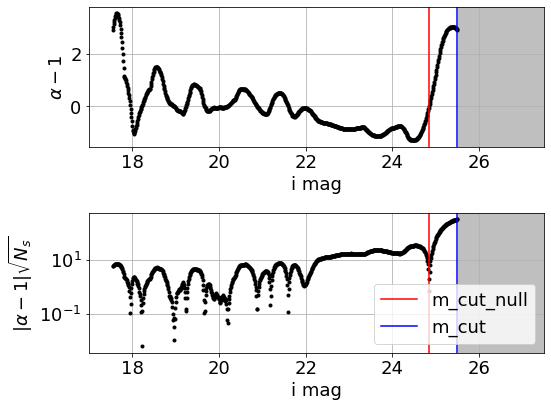

In [148]:
alpha_derivation(gal_cat['mag_i_lsst'][LBGp], 17, 26, 0.01, 25.5, show_plots='False')

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(25.495, 4.527790988528677, 24.390189895189895)

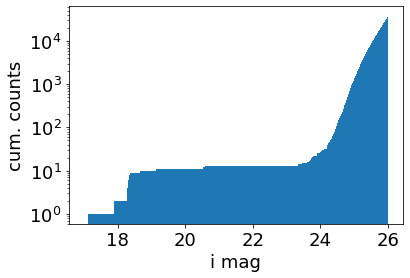

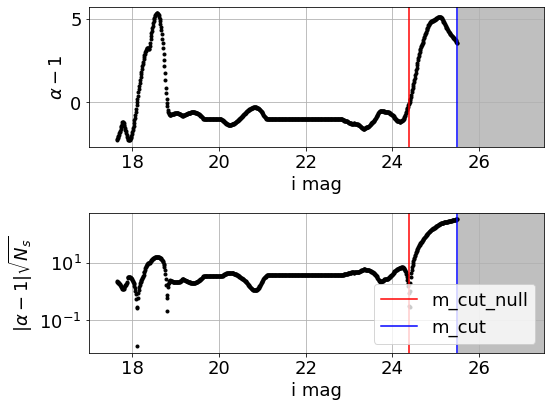

In [160]:
alpha_derivation(gal_cat['mag_i_lsst'][Udrop], 17., 26., 0.01, 25.5, show_plots='True')

(25.495, 4.573759634419199, -1.0)

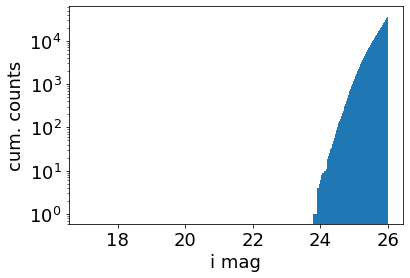

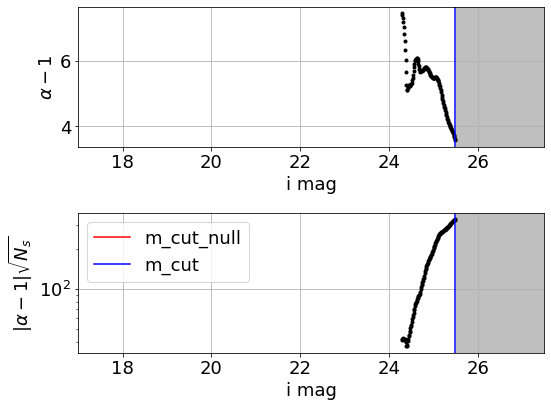

In [159]:
alpha_derivation(gal_cat['mag_i_lsst'][Udropp], 17, 26, 0.01, 25.5, show_plots='False')

(25.495, 0.7353766403337236, 24.380055985055986)

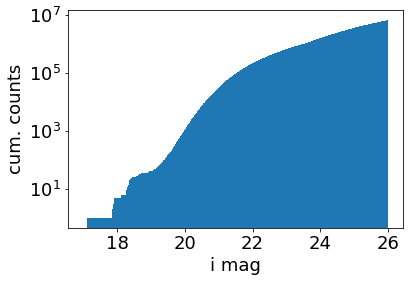

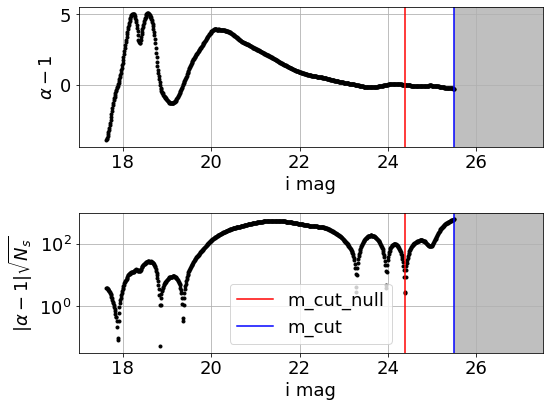

In [161]:
alpha_derivation(gal_cat['mag_i_lsst'][sel_red1], 17, 26, 0.01, 25.5, show_plots=True)

(21.755, 2.7392280665227053, 25.068681673681674)

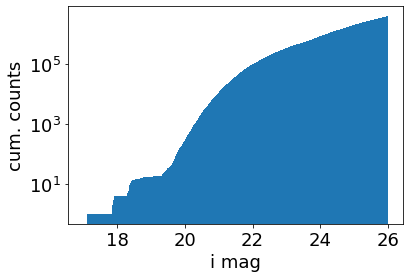

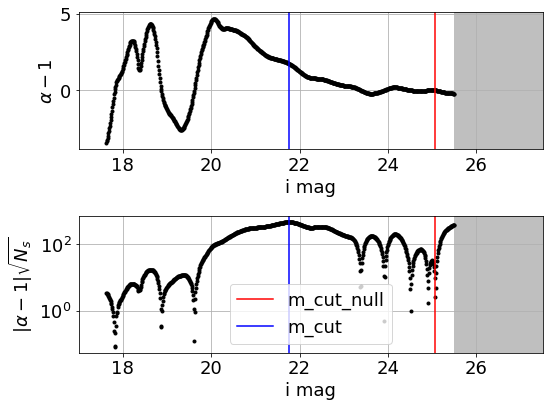

In [162]:
alpha_derivation(gal_cat['mag_i_lsst'][sel_red2], 17, 26, 0.01, 25.5, show_plots='True')

(25.495, 1.3932606707943218, 21.596829941829945)

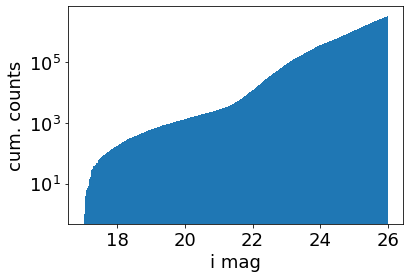

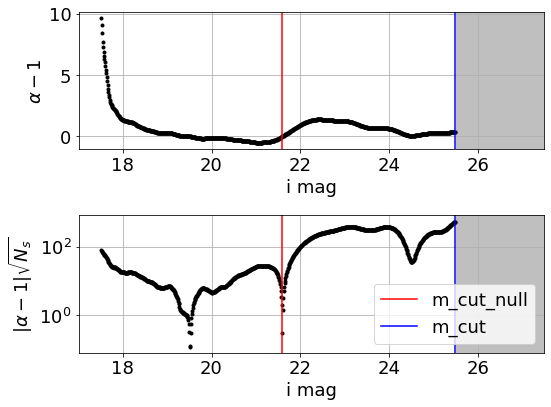

In [163]:
alpha_derivation(gal_cat['mag_i_lsst'][sel_blue1], 17, 26, 0.01, 25.5, show_plots='True')

(25.495, 1.445607157773381, 24.711383616383618)

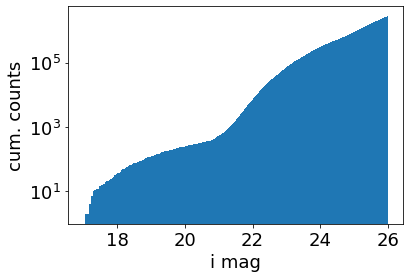

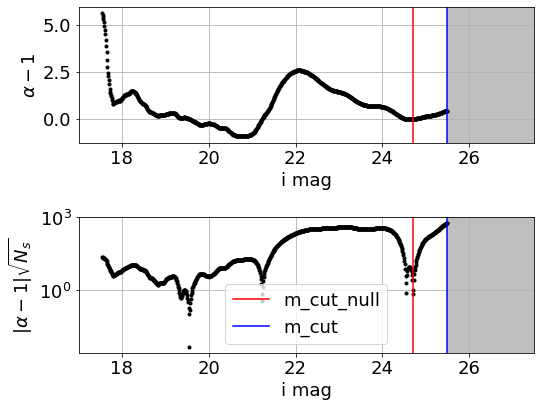

In [164]:
alpha_derivation(gal_cat['mag_i_lsst'][sel_blue2], 17, 26, 0.01, 25.5, show_plots='True')